<h1 align="center"><font face="Times New Roman">Data Analysis Project</font> </h1>
<center><font face="Times New Roman" size="4">Meghashree Madhava Rao Ramachandrahosur(21200301)</font></center>

<h2><font face="Times New Roman">Chapter 1 : Introduction</font> </h2>

<font face="Times New Roman">2016 Irish Census dataset is studied to analyze the data and deduce useful results. Census was held on 24th of April 2016 organized by Central Statistics Office (CSO). This census is conducted every 5 years when a form is collected from an individual representing the household where age, marital status, sex, place of birth, occupation, and religion are among the inquiries on this form. The data is then utilized to plan infrastructure for public transportation, healthcare, housing, and education at various levels of demographics. Census data is used by local governments to forecast demand for their services and facilities.
<br><h3>Themes used are as listed below:</h3>The census is organized into broken-down into 15 themes at 3 different demographic levels, each of which focuses on a different facet of society. Mainly, 4 themes were used in this Analysis and those are listed as follows: 
<br>1.	<b>Theme 13 - Occupation:</b> Contains information about the resident’s employment status by his/her sex and the position he holds in their respective job or not(unemployed). There is also information as a population regarding employment status in the neighborhood, Electoral area and County level.
<br>2.	<b>Theme 12 - Disability, Carers and General Health:</b> Table describes population based on Disability, Carers and General Health. The population is divided into two halves by sex, males and females.
<br>3.	<b>Theme 2 - Migration, Ethnicity, Religion, and Foreign Languages:</b> The long tables detail residents' ethnicity or cultural background, birthplace, nationality, and religion. Residents are classified into two groups depending on their English language skills and the language they speak in their native tongue. 
<br>4.	<b>Theme 10 – Education:</b> Citizens aged 15 and above are split into categories based on whether or not they completed their education, their subject of study, their gender, and the highest level of education they received
<br><h3>Goals and Aims :</h3>
The aim of this analysis is to observe and visualize how much the above theme chosen variables vary across County and Electoral neighborhood with respect to Unemployment rate in the respective demographics. It also aims to predict the <b><i>Unemployment Status(High / Low)</i></b> solely on the variables, <i>Disability, Ethnicity, Fluency in English</i> and <i>level of educational attainment</i> at the time of census conducted in the Electoral Area.
</font>

<h2><font face="Times New Roman">Chapter 2 : Data Cleaning / Pre-processing</font> </h2>

<font face="Times New Roman">
The necessary packages required to carry out the analysis and prediction were loaded. The datasets of County and Electoral Area were loaded as <i>County</i> and <i>EA</i> respectively.    
</font>

In [1]:
# Loading in Necessary Packages
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Package used to prevent warnings 
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Loading the County and Electoral Area 2016 Irish Census data

County = pd.read_csv('Census_by_county.csv', thousands=",")
EA = pd.read_csv('census_by_electoral_area.csv', thousands=",")

<font face="Times New Roman">
The datasets are checked for any duplicated values to obtain unique data so as to avoid spending time and money on analyzing similar data.    
</font>

In [3]:
# Checking for duplicates in County Dataset
County['GEOGDESC'].duplicated().any()

False

In [4]:
# Checking for duplicates in Electoral Area Dataset
EA['GEOGDESC'].duplicated().any()

True

<font face="Times New Roman">
False for County data indicates no duplicate values present in the dataset.
True for Electoral dataset indicates the presence of duplicate variables in dataset.<br>
We then find the duplicate data to make decisions to alter or completely remove it from the dataset.     
</font>

In [5]:
# Obtaining the duplicate values in Electoral Dataset
duplicate_values = EA[EA['GEOGDESC'].duplicated(keep=False)]
print(duplicate_values)

                               GUID       GEOGID GEOGDESC  T1_1AGE0M  \
5  2AE196293F6A13A3E055000000000001  LEA2014_006  Athlone        146   
6  2AE196293F0813A3E055000000000001  LEA2014_007  Athlone        216   

   T1_1AGE1M  T1_1AGE2M  T1_1AGE3M  T1_1AGE4M  T1_1AGE5M  T1_1AGE6M  ...  \
5        141        123        159        163        157        160  ...   
6        207        212        208        213        235        245  ...   

   T15_1_TC  T15_2_Y  T15_2_N  T15_2_NS  T15_2_T  T15_3_B  T15_3_OTH  T15_3_N  \
5      6901     4669     2070       162     6901     4196        965     1576   
6     11358     7373     3526       459    11358     7281       1222     2438   

   T15_3_NS  T15_3_T  
5       164     6901  
6       417    11358  

[2 rows x 802 columns]


<p><font face="Times New Roman">
As observed from the above results, there are 2 entries for the area <u>Athlone</u> with different GUID and GEOGID, implying that these are 2 different areas. On looking into the data further, it was found that the first Athlone belongs to Roscommon and the second Athlone to Westmeath. This is purely a case of <i><b>mis-labelling</b></i> and hence the data is renamed with their Counties as suffices to solve the duplicate data problem.
</font></p>

In [6]:
# Obtaining index at the duplicate value to modify the dataset
index = list(duplicate_values.index)

EA.loc[index[0], 'GEOGDESC'] = 'Athlone - Roscommon'
EA.loc[index[1], 'GEOGDESC'] = 'Athlone - Westmeath'

# checking for duplicacy again
EA['GEOGDESC'].duplicated().any()

False

<font face="Times New Roman">
Prior to starting the analysis, the variables of interest's are cleaned and obtained in the right format to aid the analysis for best results.
This is achieved by structuring the data in a sensible manner by giving the variables informative names, converting the categorical variables into weighted averages(covariates) and binary variables.
    <br><h3>2.1 Theme Variable Description</h3>
<h4>Theme 13 - Occupation Variables
</h4>This theme was used to obtain the Unemployment Rate in the County and Electoral Area by assuming the <i>'Non-Sated'</i> as unemployed and the rest to be employed. The Ratio of 'Not-Stated' to the total residents in the Area were considered to obtain the Unemployment Rate.
</font>

In [7]:
# Theme 13 - Occupation
# Calculation of Unemployment rate

# Use of Regex to find the variables
Employed_County = County.filter(regex='GEOGDESC|^T13_1..*T$')
Count = len(Employed_County.columns)
UnempRate_County = []
for i in range(0, 31): 
    UnempRate_County.append(Employed_County.iloc[i,Count-2]/Employed_County.iloc[i,Count-1])

# Use of Regex to find the variables
Employed_EA = EA.filter(regex='GEOGDESC|^T13_1..*T$')
Count = len(Employed_EA.columns)
UnempRate_EA = []
for i in range(0, 137):
    UnempRate_EA.append(Employed_EA.iloc[i,Count-2]/Employed_EA.iloc[i,Count-1])

<font face="Times New Roman">
<h4>Theme 10 - Education</h4>
Mode of instruction assumes a significant part in deciding work status. Consequently the "Level of Training" table factors were considered for the examination. There are 10 degrees of schooling present. The occupants with most elevated level of schooling were henceforth given a score of 10 and the inhabitants who have gotten least degree of training, a score of 1. The occupants in the Discretionary Region who have not gotten any proper schooling hve been given a score 0 to show no instruction. Since the information was organized in rising request of Level of Instruction, they exhibit of training scores are from [0,10]. The proportion of absolute instruction Nearby to add up to populace was considered to change over the downright factor into control variable(covariate). This proportion shows the Degree of Instruction in the District and Electing region are acquired as factors <b><i>Edu_County</i></b> and <b><i>Edu_EA</i></b> individually .High proportion demonstrates significant degree of training and lower proportions show occupants who for the most part stopped schooling at beginning phases.
</font>

In [8]:
# Theme 10 - Education
# Education Score

Edu = np.array([0,1,2,3,4,6,6,7,8,9,10])
# Education Score for each County
EduCounty_df = County.filter(regex='GEOGDESC|^T10_4..*T$')
Count = len(EduCounty_df.columns)
Edu_County = []
for i in range(0, 31):
    Edu_County.append(sum((EduCounty_df.iloc[i,1:Count-2])*Edu)/(EduCounty_df.iloc[i,Count-1]))

# Education Score for each Electoral Area
EduEA_df = EA.filter(regex='GEOGDESC|^T10_4..*T$')
Count = len(EduEA_df.columns)
Edu_EA = []
for i in range(0, 137):
    Edu_EA.append(sum((EduEA_df.iloc[i,1:Count-2])*Edu)/(EduEA_df.iloc[i,Count-1]))

<font face="Times New Roman">
    <h4>Theme 12 - Disability, Carers and General Health</h4>
Ireland has seen multiple articles about how less than half of the population with disability are employed in the irish job market. Just 36 % of those with a disability are in the workforce compared with two-thirds of those without. This statistic puts Ireland fourth from the bottom in a ranking of 28 countries in Europe.Disability proportion is obtained by the ratio of total residents with disabilities to the total population and stored as <b><i>Disability_County</i></b> and <b><i>Disability_EA</i></b> in County and Electoral Area respectively.  
</font>

In [9]:
# Theme 12: Disability, Carers and General Health:
# Disability Ratio - % occupants with Disability

Disability_County = []
for i in range(0,31):
    Disability_County.append(County['T1_1AGETT'][i]/County['T12_1_T'][i])

Disability_EA = []
for i in range(0,137):
    Disability_EA.append(EA['T1_1AGETT'][i]/EA['T12_1_T'][i])

<font face="Times New Roman">
<h4>Theme 2 - Migration, Ethnicity, Religion, and Foreign Languages</h4>The main language used for communication in the Industry is predominantly English. Hence fluency in english is one of the parameters considered that affects the employment in a particular area. As the fluency in english table is arranged from 'Very Well' to  'Not at all'(decreasing order), the scores as <i>Fluency</i> array is from  3 to 0. Individuals who did not state their fluency were considered to not speak English at all. High average sum of these scores indicates good fluency in english in that particular area and low value areas as residents with lack of English speaking skills. These values are stored as <b><i>Fluency_County</i></b> and <b><i>Fluency_EA</i></b> in County and Electoral Area respectively.   
    
Another variable considered from this theme is Nationality. There have been multiple discussion articles about national discrimination during the hiring process in European countries.  this might be due to the visa status each person holds in ireland and how the employer might have to invest more. To verify this, total Non_EU nationals were considered. This variable was stored as <b><i>NonEU_County</i></b> and <b><i>NonEU_EA</i></b> in County and Electoral Area respectively. 
</font>

In [10]:
# Theme 2 - Migration, Ethnicity, Religion, and Foreign Languages
# Fluency in English

Fluency = np.array([3,2,1,0])

# Fluency of english spoken in each County
English_County = County.filter(regex='GEOGDESC|^T2_6..*')
Count = len(English_County.columns)
Fluency_County = []
for i in range(0, 31):
    Fluency_County.append(sum((English_County.iloc[i,1:Count-2])*Fluency)/(English_County.iloc[i,Count-1]-English_County.iloc[i,Count-2]))

# Fluency of english spoken in each Electoral Area
English_EA = EA.filter(regex='GEOGDESC|^T2_6..*')
Count = len(English_EA.columns)
Fluency_EA = []
for i in range(0, 137):
    Fluency_EA.append(sum((English_EA.iloc[i,1:Count-2])*Fluency)/(English_EA.iloc[i,Count-1]-English_EA.iloc[i,Count-2]))

In [11]:
# Theme 2 - Migration, Ethnicity, Religion, and Foreign Languages
# Nationality - EU residents in Ireland %
EU_County = []
for i in range(0,31):
    EU_County.append(1- (County['T2_1RWN'][i]/County['T2_1TN'][i]))
EU_EA = []
for i in range(0,137):
    EU_EA.append(1- (EA['T2_1RWN'][i]/EA['T2_1TN'][i]))

<font face="Times New Roman"><h3>2.2 Assembling Data obtained into Dataframe</h3>
The collected variables as per requirements as control variables are gathered together into a pandas dataframe for County and Electoral Area as <b><i>df_county</i></b> and <b><i>df_EA</i></b> 
<br>The data is then checked for any 'NA' or null values and Unemployment Rate variable of electoral dataset is converted into Binary data for prediction during this Analysis using median(the central tendancy) as the cut value to dicide the data into High or Low Unemployment regions. In total there are 137 Electoral Areas in the dataset out of which 69 districts have high unemployment and the remaining 68 have low unemployment(most residents are employed).
</font> 

In [12]:
data_county = {'Unemployment_Rate': UnempRate_County, 'Edu_Level': Edu_County, 'Disability': Disability_County, 'EU_National': EU_County, 'Fluency': Fluency_County}
df_county = pd.DataFrame(data = data_county, index = County['GEOGDESC'])
df_county= df_county.dropna()

data_EA = {'Unemployment_Rate': UnempRate_EA, 'Edu_Level': Edu_EA, 'Disability': Disability_EA, 'EU_National': EU_EA, 'Fluency': Fluency_EA}
df_EA = pd.DataFrame(data = data_EA, index = EA['GEOGDESC'])
df_EA = df_EA.dropna()

#Converting Unemployment Rate into covariate form for Electoral Data for prediction

cut_value = df_EA['Unemployment_Rate'].median()
min_value = df_EA['Unemployment_Rate'].min()
max_value = df_EA['Unemployment_Rate'].max()

df_EA['Level_of_unemp'] = pd.cut(df_EA['Unemployment_Rate'], bins=[min_value, cut_value, max_value+1], labels=np.arange(2), right=False)
df_EA['Level_of_unemp'].value_counts()

1    69
0    68
Name: Level_of_unemp, dtype: int64

 <font face="Times New Roman"><h2>Chapter 3: Exploratory Data Analysis</h2><h3>3.1 Inferences from Summary Staistics</h3>
Data is displayed to visualize and observe the variation in all variables with respect to Unemployment_Rate at each County and Electoral. When data is arranged in ascending order, we can see that as Unemployment Rate increases, Edu_Level decreases, Sex_Ratio increases, Fluency in English decreases. Nationality has a vague positive pattern along with all variables either increasing or decreasing. This implies that level of education and fluency in english has a negative relationship and  Sex Ratio has a positive relationship between Unemployment Rate in the area. 

At County level, unemployment is the highest in Carlow, Dublin City, Longford and lowest in Dun Laoghaire, Cork and Kilkenny. Longford, Tallaght - South, North Inner City Electoral areas have highest level of Unemployment and Stillorgan, Dundrum and Athenry - Oranmore Electoral Areas have the lowest. On closely discerning unemployment at different levels of demographics, the tails increase as the Areas are broken down into more sub areas. The highest unemployment ratio at County and Electoral area differs greatly by 7.7% with North Inner City having 23% of its occupants unemployed. This might be due to various factors related to high population of Non-EU community and low job intake, even with high education level attainment.</font>

In [13]:
print('\033[1m' + "\n Top and bottom 3 County data collected after cleaning of data to observe the relationship\n" + '\033[0m')
print(df_county.sort_values('Unemployment_Rate').head(3),'\n\n',df_county.sort_values('Unemployment_Rate').tail(3))

print('\033[1m' + "\nTop and bottom 3 Electoral area data colected after cleaning of data to observe the relationship\n" + '\033[0m')
print(df_EA.sort_values('Unemployment_Rate').head(3),'\n\n',df_EA.sort_values('Unemployment_Rate').tail(3))


 Top and bottom 3 County data collected after cleaning of data to observe the relationship

                        Unemployment_Rate  Edu_Level  Disability  EU_National  \
GEOGDESC                                                                        
D�n Laoghaire-Rathdown           0.060683   5.627549    7.995966     0.958008   
Cork County                      0.068816   4.449779    7.922881     0.984938   
Kilkenny                         0.077580   4.182617    7.443144     0.987913   

                         Fluency  
GEOGDESC                          
D�n Laoghaire-Rathdown  2.574341  
Cork County             2.375513  
Kilkenny                2.347167   

              Unemployment_Rate  Edu_Level  Disability  EU_National   Fluency
GEOGDESC                                                                    
Carlow                0.130231   3.858182    6.911740     0.984578  2.263927
Dublin City           0.148359   4.472276    6.804177     0.934288  2.446376
Longford       

In [14]:
#Comparing Unemployment at Different levels of demography

print('\n\033[1m', 'Unemployement rate at County Level\n','\033[0m',df_county['Unemployment_Rate'].describe())

print('\033[1m','\nUnemployement rate at Democratic Level\n','\033[0m',df_EA['Unemployment_Rate'].describe())


 Unemployement rate at County Level
  count    31.000000
mean      0.102174
std       0.022113
min       0.060683
25%       0.087147
50%       0.100951
75%       0.117314
max       0.153143
Name: Unemployment_Rate, dtype: float64
 
Unemployement rate at Democratic Level
  count    137.000000
mean       0.101058
std        0.034255
min        0.045311
25%        0.078041
50%        0.095504
75%        0.117594
max        0.230130
Name: Unemployment_Rate, dtype: float64


Text(0.5, 1.0, 'Unemployment in each County')

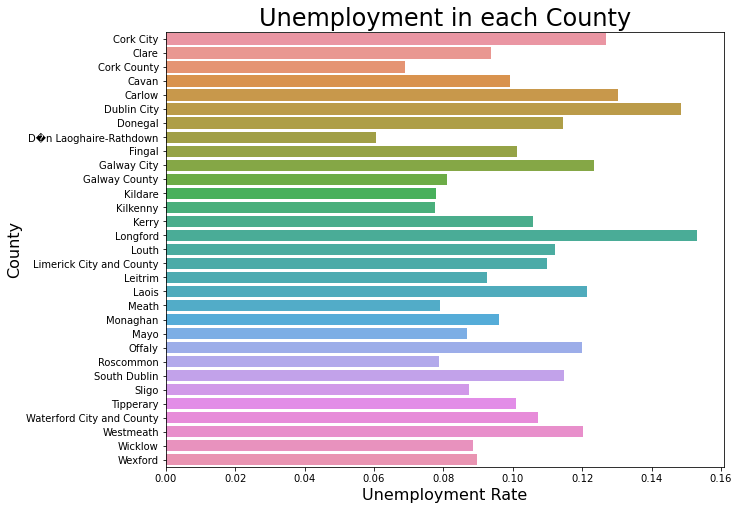

In [15]:
#Visualization for easier Interpretation of Unemployment in different County
plt.figure(figsize=(10,8))
bplot1 = sns.barplot(x=df_county.Unemployment_Rate, y=df_county.index)
plt.xlabel('Unemployment Rate', size=16)
plt.ylabel('County', size=16)
plt.title("Unemployment in each County", size=24)

<font face="Times New Roman">Keeping in mind that Disability has been a topic of concern in important articles pertaining to job hiring, the bargraph of unemployment for residents with Disability was plotted. We can observe a negative relationship between unemployment rate and disability, completely opposite to what was expected. Overall in April 2016, 6.5% of those at work had a disability. The employment rate of persons with a disability was <b><i>28.6% in 2013</i></b>. This fell to <b><i>27.4% in 2014</i></b>. The rate has increased since then and was <b><i>29.0% in 2016</i></b>. This might be due to <i>Disability Act</i> that came into effect in 2005, which stated that public bodies are required to make their public buildings accessible to people with disabilities by <u>2015</u>.

Text(0, 0.5, 'Unemployment Rate')

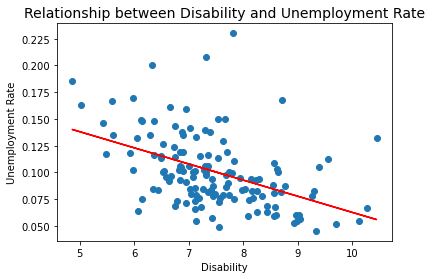

In [16]:
# Comparing Unemployment for populational with Disability at County level

# plotting and visualizing

plt.scatter(df_EA['Disability'],df_EA['Unemployment_Rate'])
a, b = np.polyfit(df_EA['Disability'],df_EA['Unemployment_Rate'],1)
plt.plot(df_EA['Disability'], (a*df_EA['Disability'])+b, color = 'red')
plt.title('Relationship between Disability and Unemployment Rate', size =14)
plt.xlabel('Disability')
plt.ylabel('Unemployment Rate')

<font face="Times New Roman"><h3>3.2 Relationship between variables</h3>
The Scatterplot matrix, also called as pairplot is used to see distribution of variables and relationships between two variables to identify trends for follow-up analysis. The Binary variable, <i>Unemployment Status</i> is used to visualise the Electoral dataset divided by Level of Unemployment '0' for low level of unemployment and '1' for high level of unemployment.
The diagonal of the pairplot provides a histogram with semantic mapping to show the marginal distribution of the data in each column.

Looking into the histogram for Edu_Level we can say that areas with most people employed have their residents who have attained high degree of education. Unemployment in the year 2015-2016 increases with the number of residents with disability in the region. Due to the implementation of acts, employment rate for disability saw positive effect. We can also observe the Status difference in unemployment with EU and Non-EU population. We can hence consider nationality as one of the parameters in hiring process.

We can see that even the slight variation in fluency has an affect on employment rates and the histograms do not completely overlap, hence making it evident that all the 4 variables are correlated with Level of Unemployment.

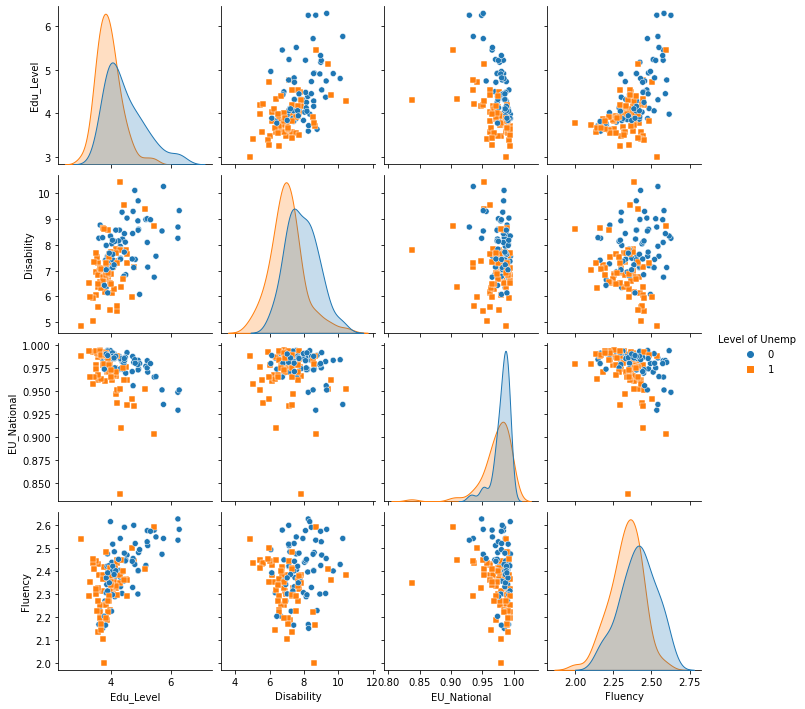

In [17]:
#Observing relationship between the chosen variables using Pairplot

pp = sns.pairplot(df_EA.drop('Unemployment_Rate', axis = 1), hue='Level_of_unemp', markers=['o','s'])
pp._legend.set_title('Level of Unemp')

<font face="Times New Roman">On looking into the pair plot, there is a fear of multi-collinearity between the chosen variables which is tested in the later analysis. The presence of a ordinal variable, <i>Level_of_unemp</i> makes Spearman Rank Correlation an ideal method to be used over the most widely used Pearson's Correlation.
<br>All the variables are well correlated with level of unemployment with Nationality having the highest positive correlation and Fluency having the least. Level of Education and Nationality fluency have a positve relationship with level of unemployment variable when compared to Sex Ratio and ability to speak in English.

In [18]:
#Spearman correlation for association between variables
coef = spearmanr(df_EA.drop('Unemployment_Rate',axis=1))[0]
Corr = pd.DataFrame(coef, index = ['Level_of_unemp','Edu_Level','Sex_Ratio','Nationality','Fluency'], columns = ['Level_of_unemp','Edu_Level','Sex_Ratio','Nationality','Fluency'])
print(Corr)

                Level_of_unemp  Edu_Level  Sex_Ratio  Nationality   Fluency
Level_of_unemp        1.000000   0.522705  -0.473528     0.578948 -0.454423
Edu_Level             0.522705   1.000000  -0.032025     0.140450 -0.446302
Sex_Ratio            -0.473528  -0.032025   1.000000    -0.270614 -0.186790
Nationality           0.578948   0.140450  -0.270614     1.000000 -0.334450
Fluency              -0.454423  -0.446302  -0.186790    -0.334450  1.000000


<font face="Times New Roman"><h2>Chapter 4 : Statistical Analysis</h2><h3>4.1 Standardizing data and multicollinearity check</h3>
The extracted variables of interest which are correlated with Level of employment are now fit to a logistic regression model.The numerical variables are not standardized and multicollinearity checks are performed using Variation Inflation Factor (VIF).
    
<b>Variance inflation factor (VIF)</b> is a measure of the amount of multicollinearity in a set of multiple regression variables. A high VIF indicates that the associated independent variable is highly collinear with the other variables in the model. It is measured as<br> 
    $$ VIF = \frac{1}{1-R^{2}} $$

A VIF above 10 indicates high correlation and is cause for concern. Some analysts suggest a more conservative level of 2.5 or above. Sometimes a high VIF is no cause for concern at all.

In [19]:
df_EA = df_EA.drop('Unemployment_Rate', axis=1)
df_EA_num = df_EA.drop('Level_of_unemp', axis=1)
df_EA_std = (df_EA_num - df_EA_num.mean())/df_EA_num.std()

<font face="Times New Roman">The data is now divided into dependent and independent variables, followed by the calculation of <i>VIF factor</i> as a symptomatic check for multicollinearity.

In [20]:
X = df_EA_std 
y = df_EA['Level_of_unemp']

In [21]:
#Check for multicollinearity
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

calc_vif(df_EA_std)

,variables,VIF
0,Edu_Level,2.832730
1,Disability,1.624802
2,EU_National,1.280714
3,Fluency,1.708081


<font face="Times New Roman">Since all the variables are less than 5, none of the explainatory variables are of correlated amongst themselves.
    <br><h3>4.2 Building a Logistic Regression model for Prediction</h3>
    <b>Splitting of Data</b>
    <br>To build a regression model we need to first split the data into train and test datasets. The Electoral data is now split into train and test dataset using <i>train_test_split</i> which is used to estimate the performance of machine learning algorithm(in our case Logistic Regression) when they are used to make predictions on data not used to train the model(test data). The Electoral dataset was split into 80-20 where 80% of the data was used to train the model and rest 20% was used to test the accuracy of the model predictions. A parameter <b><i>random_state</i></b> is used and seeded an integer input to produce the same results across different calls.

In [22]:
# Split data into train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=0)

<font face="Times New Roman"><b>Logistic Regression</b><br>Logistic regression is a statistical model that in its basic form uses a logistic function to model a binary(0,1) dependent variable. Here we fit the train model to test the accuracy of the explainatory variables. Hence checking the variables for its statistical significance.

In [23]:
logreg = LogisticRegression(solver='lbfgs')
logreg.fit(X_train, y_train)
logreg_test_pred = logreg.predict(X_test)
print("Accuracy of this model is {:.2f}".format(logreg.score(X_test, y_test)*100))

Accuracy of this model is 78.57


<font face="Times New Roman">The confusion matrix below shows that out of the 14 observations within the testing set,where 9 electoral areas were correctly classified as zones with low unemployment rate and 13 were correctly classified as high-class. On the other hand, 5 areas were incorrectly classified as zones with low unemployment rate, and 1 was incorrectly classified as zones with high unemployment rate. The Confusion matrix is later plotted to show the division of true/false positives and negatives. Sensitivity and specificity of the data is displayed for a clear picture of division.

In [24]:
#Generate the confusion matrix
confusion_matrix = confusion_matrix(y_test, logreg_test_pred)

print(confusion_matrix)

[[ 9  5]
 [ 1 13]]


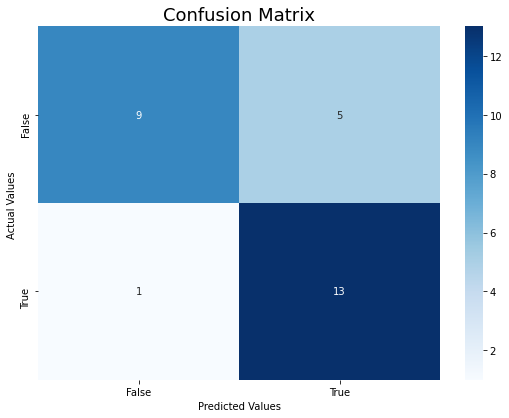

In [25]:
plt.subplots(1, figsize=(9,6.5))
axis = sns.heatmap(confusion_matrix, annot=True, cmap='Blues')

# Axis labels
axis.set_title('Confusion Matrix', size='18');
axis.set_xlabel('Predicted Values')
axis.set_ylabel('Actual Values ');

# Ticket labels
axis.xaxis.set_ticklabels(['False','True'])
axis.yaxis.set_ticklabels(['False','True'])

# Display the visualization of the Confusion Matrix.

plt.show()

In [26]:
true_positive = confusion_matrix[1,1]
true_negative = confusion_matrix[0,0]
false_positive = confusion_matrix[0,1]
false_negative = confusion_matrix[1,0]
sensitivity = float(true_positive)/(true_positive + false_negative)
specificity = float(true_negative)/(true_negative + false_positive)
print('Sensitivity = {:.2f}'.format(sensitivity*100))
print('Specificity = {:.2f}'.format(specificity*100))

Sensitivity = 92.86
Specificity = 64.29


<font face="Times New Roman">
The true classification rate of high level of unemployment is 92.86% indicating the models accuracy to classify an Electoral Area as '1'. Where as the true classification rate of low level of unemployment is 64.29% indicating the models accuracy to classify an Electoral Area as '0'. This might be due to many parameters that are not consider that determine high level of employment, such as Economic Factors, Technological Advances and Automation, global competition and other factors.
<br>Therefore the overall accuracy of the model with used parameters is 79%. This is considered a good prediction accuracy, but this could be considerably made better with more significant parameters. 
The Receiver operating characteristic curve is used to show the trade off between the specificity
and the sensitivity of the model. Since the ROC Curve is moderately far from the red dotted line, the model accuracy is good.

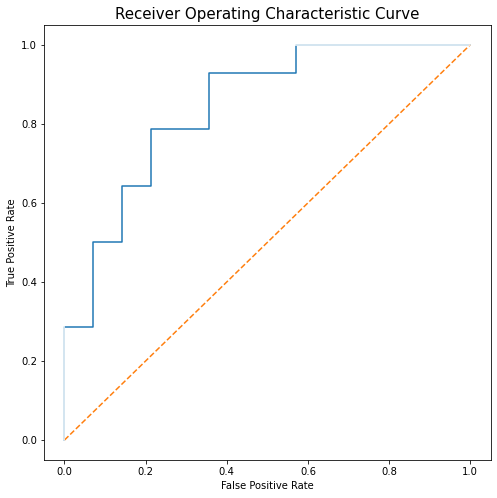

In [27]:
# ROC Curve
roc_score = logreg.predict_proba(X_test)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, roc_score)

plt.subplots(1, figsize=(8,8))
plt.title('Receiver Operating Characteristic Curve', size='15')
plt.plot(false_positive_rate, true_positive_rate, label="ROC curve (area = %0.2f)" % roc_score[2])
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c="1"), plt.plot([1, 1] , c="1")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

<font face="Times New Roman"><h2>Chapter 5 : Conclusion</h2>
Unemployment has expenses for a general public that are something other than monetary. Unemployed people lose pay as well as face difficulties to their physical and psychological wellness. Administrative expenses go past the installment of advantages to the deficiency of the development of laborers, which decreases the total national output inturn having an effect on the economy<i>(Gross domestic product)</i>.Considering the significant impact of employment on both individuals and the Country's economy, factors like Disability, Nationality, level of education and fluency in english was considered. These factors were mainly focused on because of the high increase in student population of different nationality, coming to Ireland for it's high quality of education and job opportunities. 
    
We were provided with 2016 Census data. <i>Disability</i> for employment was considered as one of the parameters because, work is a significant piece of having a place and partaking in the public arena. Having some work is great for psychological wellness. Aside from acquiring a pay, work is an important social outlet, removing individuals from the house to turn out to be essential for a more extensive local area. Absence from workdue to disabilities can add to social separation, and joblessness is related with a higher frequency of psychological wellness issues. Partaking in the labor force additionally offers individuals with inabilities the opportunity to make a positive commitment. <i>Nationality</i> also is of interest due to the bias in job intake due to Visa Status. The results obtained from the analysis, may be used by the government to create more impactful Policies and Acts to aid the minorities with good opprtunities and inturn improve economy of the Country. Nationality and education act as a major parameter to obtain job along with fluency in english since it is a main mode of communication in Ireland. Reduction in discremination on various grounds brings opportunities to Country at individual level, reducing the unemployment rate. The models ability to predict the high unemployment level can be used for the government to focus on smaller groups for personal imporvement.
    
Suggestions for future can be made to improve the model by including additional parameters during the census(question inclusions in the census form). Residents can be questioned about total government grants received if any and if an individual at manual labour lost work due to advancements in technology. Basic education for manual workers might be provided. 